In [208]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

In [133]:
csv_files_2017 = [('2017' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files_2018 = [('2018' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files_2019 = [('2019' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files = csv_files_2017 + csv_files_2018 + csv_files_2019

In [134]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [135]:
def to_datetime(df):
    df1 = df.copy()
    df1['starttime'] = pd.to_datetime(df1['starttime'])
    df1['stoptime'] = pd.to_datetime(df1['stoptime'])
    df1['start_date'] = df1['starttime'].dt.date
    df1['start_time'] = df1['starttime'].dt.time
    df1['start_hour'] = df1['starttime'].dt.hour
    df1['start_min'] = df1['starttime'].dt.minute
    df1['start_year'] = df1['starttime'].dt.year
    df1['start_month'] = df1['starttime'].dt.month
    df1['start_dayofweek'] = df1['starttime'].dt.weekday   # Monday is 0, Sunday is 6
    #df1['start_dayofweek'] = df1['starttime'].dt.weekday_name  # The name of day in a week (e.g. Monday)
    df1['stop_date'] = df1['stoptime'].dt.date
    df1['stop_time'] = df1['stoptime'].dt.time
    df1['stop_hour'] = df1['stoptime'].dt.hour
    df1['stop_min'] = df1['stoptime'].dt.minute
    df1['stop_dayofweek'] = df1['stoptime'].dt.weekday
    return df1

In [136]:
def ignore_offpeak(df):
    df1 = df.copy()
    mask = df1['start_hour'].apply(lambda x: 5 <= x <= 20)
    return df1[mask]

In [206]:
def aggregated_data(df):
    # Calculate daily trip counts, avg trip duration, and avg trip distance and merge to original df
    # Method 1: use long and lat to estimate distance travelled 
#     log_diff = df['end_station_longitude']-df['start_station_longitude']
#     lat_diff = df['end_station_latitude']-df['start_station_latitude']
#     df['distance'] = abs(log_diff)*53 + abs(lat_diff)*69
    # Method 2: Naive way of estimating distance based on an average speed of 7.456 mph
    df['distance'] = df['trip_duration']*7.456/3600
    df_daily = df.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
    df_daily_merged = df.merge(df_daily, how = 'left', on = 'start_date')
    # Calculate hourly trip counts, avg trip duration, and avg trip distance per station and merge to above df
    df_hourly = df_daily_merged.groupby(['start_station_ID','start_date','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly.columns = ['start_station_ID','start_date','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
    df_hourly_merged = df_daily_merged.merge(df_hourly, how = 'left', on = ['start_station_ID','start_date','start_hour'])
    return df_hourly_merged    

In [139]:
def merge_bikecount(df):
    # groupby start station ID, date and hour to get hourly counts of trips per start station
    checkout = df.groupby(['start_station_ID','start_date','start_hour'])['trip_duration'].count().reset_index()
    checkout.columns = ['start_station_ID','start_date','start_hour','checkout_counts']
    # groupby end station ID, date, and hour to get hourly counts of trips per end station 
    checkin = df.groupby(['end_station_ID','stop_date','stop_hour'])[['trip_duration']].count().reset_index()
    checkin.columns=['end_station_ID','stop_date','stop_hour','checkin_counts']
    # Join dataframe to get station checkin and checkout counts 
    temp = pd.merge(checkout, checkin,  how='outer', left_on=['start_station_ID','start_date','start_hour'], 
                    right_on = ['end_station_ID','stop_date','stop_hour'])
    temp['start_station_ID'] = temp['start_station_ID'].fillna(temp['end_station_ID'])
    temp['start_date'] = temp['start_date'].fillna(temp['stop_date'])
    temp['start_hour'] = temp['start_hour'].fillna(temp['stop_hour'])
    temp['checkout_counts'] = temp['checkout_counts'].fillna(0)
    temp['checkin_counts'] = temp['checkin_counts'].fillna(0)
    temp = temp.drop(['end_station_ID','stop_date','stop_hour'],axis=1)
    temp.columns=['station_ID','date','hour','checkout_counts','checkin_counts']
    temp['bike_added'] = temp['checkin_counts'] - temp['checkout_counts']
    # merge orginal dataframe to get hourly checkin/checkout information for both start and stop stations 
    df_temp_merged = pd.merge(df, temp,  how='left', left_on=['start_station_ID','start_date','start_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1)
    df_temp_merged = pd.merge(df_temp_merged, temp,  how='left', left_on=['end_station_ID','stop_date','stop_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1) 
    df_temp_merged = df_temp_merged.rename(columns={'checkout_counts_x':'start_station_checkout_counts',
                                                    'checkin_counts_x':'start_station_checkin_counts',
                                                    'bike_added_x':'start_station_bike_added', 
                                                    'checkout_counts_y':'end_station_checkout_counts',
                                                    'checkin_counts_y':'end_station_checkin_counts',
                                                    'bike_added_y':'end_station_bike_added'}) 
    return df_temp_merged
    

In [202]:
Jan2017 = pd.read_csv('../Tripdata/201701-citibike-tripdata.csv',index_col = 0).reset_index()
Jan2017.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
                       'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
                       'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']

In [204]:
# Seasonal Change
# log_diff = Jan2017['end_station_longitude']-Jan2017['start_station_longitude']
# lat_diff = Jan2017['end_station_latitude']-Jan2017['start_station_latitude']
# Jan2017['distance'] = abs(log_diff)*53 + abs(lat_diff)*69
Jan2017['distance_simple'] = Jan2017['trip_duration']*7.456/3600
Jan2017.loc[Jan2017['distance']==0]
# Jan2017 = to_datetime(Jan2017)
# Jan2017_daily = Jan2017.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
# Jan2017_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
# Jan2017_daily_merged = Jan2017.merge(Jan2017_daily, how = 'left', on = 'start_date')
# Jan2017_daily_merged

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,distance,distance_simple
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163,Central Park West & W 68 St,40.773407,-73.977825,3163,Central Park West & W 68 St,40.773407,-73.977825,16050,Subscriber,2000.0,1,0.0,1.379360
22,570,2017-01-01 00:10:50,2017-01-01 00:20:20,301,E 2 St & Avenue B,40.722174,-73.983688,301,E 2 St & Avenue B,40.722174,-73.983688,21400,Subscriber,1996.0,1,0.0,1.180533
59,81,2017-01-01 00:17:57,2017-01-01 00:19:18,3137,5 Ave & E 73 St,40.772828,-73.966853,3137,5 Ave & E 73 St,40.772828,-73.966853,17507,Subscriber,1969.0,1,0.0,0.167760
134,1331,2017-01-01 00:29:29,2017-01-01 00:51:41,3168,Central Park West & W 85 St,40.784727,-73.969617,3168,Central Park West & W 85 St,40.784727,-73.969617,26780,Subscriber,1971.0,1,0.0,2.756649
194,100,2017-01-01 00:38:14,2017-01-01 00:39:54,3383,Cathedral Pkwy & Broadway,40.804213,-73.966991,3383,Cathedral Pkwy & Broadway,40.804213,-73.966991,17910,Customer,NaN,0,0.0,0.207111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726630,1428,2017-01-31 23:49:11,2017-02-01 00:13:00,128,MacDougal St & Prince St,40.727103,-74.002971,128,MacDougal St & Prince St,40.727103,-74.002971,18683,Subscriber,1988.0,1,0.0,2.957547
726660,942,2017-01-31 23:55:12,2017-02-01 00:10:55,3160,Central Park West & W 76 St,40.778968,-73.973747,3160,Central Park West & W 76 St,40.778968,-73.973747,27307,Subscriber,1986.0,1,0.0,1.950987
726673,79,2017-01-27 04:59:49,2017-01-27 05:01:08,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,0.0,0.163618
726674,711,2017-01-27 06:23:29,2017-01-27 06:35:21,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,0.0,1.472560


In [201]:
# Hourly Change
Jan2017_hourly = Jan2017_daily_merged.groupby(['start_station_ID','start_date','start_hour']).\
agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
Jan2017_hourly.columns = ['start_station_ID','start_date','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
Jan2017_hourly_merged = Jan2017_daily_merged.merge(Jan2017_hourly, how = 'left', on = ['start_station_ID','start_date','start_hour'])
Jan2017_hourly_merged

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,distance,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,1.408356,2017-01-01,00:00:21,0,0,2017,1,6,2017-01-01,00:11:41,0,11,6,16009,1149.873009,2.381515,2,716.500000,1.483951
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2.655164,2017-01-01,00:00:45,0,0,2017,1,6,2017-01-01,00:22:08,0,22,6,16009,1149.873009,2.381515,2,1892.000000,3.918542
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0,1.342080,2017-01-01,00:00:57,0,0,2017,1,6,2017-01-01,00:11:46,0,11,6,16009,1149.873009,2.381515,15,1351.733333,2.799590
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0,1.306871,2017-01-01,00:01:10,0,1,2017,1,6,2017-01-01,00:11:42,0,11,6,16009,1149.873009,2.381515,15,1351.733333,2.799590
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0,1.286160,2017-01-01,00:01:25,0,1,2017,1,6,2017-01-01,00:11:47,0,11,6,16009,1149.873009,2.381515,15,1351.733333,2.799590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726671,340,2017-01-31 23:59:14,2017-02-01 00:04:55,267,Broadway & W 36 St,40.750977,-73.987654,527,E 33 St & 2 Ave,40.744023,-73.976056,17133,Subscriber,1977.0,1,0.704178,2017-01-31,23:59:14,23,59,2017,1,1,2017-02-01,00:04:55,0,4,2,25169,663.512376,1.374208,1,340.000000,0.704178
726672,338,2017-01-31 23:59:23,2017-02-01 00:05:01,3092,Berry St & N 8 St,40.719009,-73.958525,3110,Meserole Ave & Manhattan Ave,40.727086,-73.952991,18810,Subscriber,1972.0,1,0.700036,2017-01-31,23:59:23,23,59,2017,1,1,2017-02-01,00:05:01,0,5,2,25169,663.512376,1.374208,3,383.333333,0.793926
726673,79,2017-01-27 04:59:49,2017-01-27 05:01:08,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,0.163618,2017-01-27,04:59:49,4,59,2017,1,4,2017-01-27,05:01:08,5,1,4,32394,714.650367,1.480120,1,79.000000,0.163618
726674,711,2017-01-27 06:23:29,2017-01-27 06:35:21,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,1.472560,2017-01-27,06:23:29,6,23,2017,1,4,2017-01-27,06:35:21,6,35,4,32394,714.650367,1.480120,2,667.000000,1.381431


In [198]:
Jan2017 = Jan2017.merge(Jan2017_hourly, how = 'left', on = ['start_station_ID','start_date','start_hour'])
Jan2017

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,distance,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,W 82 St & Central Park West,40.782750,-73.971370,3165,Central Park West & W 72 St,40.775794,-73.976206,25542,Subscriber,1965.0,2,1.408356,2017-01-01,00:00:21,0,0,2017,1,6,2017-01-01,00:11:41,0,11,6,16009,1149.873009,2.381515,2,716.500000,1.483951
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,Cooper Square & E 7 St,40.729236,-73.990868,498,Broadway & W 32 St,40.748549,-73.988084,21136,Subscriber,1987.0,2,2.655164,2017-01-01,00:00:45,0,0,2017,1,6,2017-01-01,00:22:08,0,22,6,16009,1149.873009,2.381515,2,1892.000000,3.918542
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,18147,Customer,NaN,0,1.342080,2017-01-01,00:00:57,0,0,2017,1,6,2017-01-01,00:11:46,0,11,6,16009,1149.873009,2.381515,15,1351.733333,2.799590
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,21211,Customer,NaN,0,1.306871,2017-01-01,00:01:10,0,1,2017,1,6,2017-01-01,00:11:42,0,11,6,16009,1149.873009,2.381515,15,1351.733333,2.799590
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143,5 Ave & E 78 St,40.776829,-73.963888,3152,3 Ave & E 71 St,40.768737,-73.961199,26819,Customer,NaN,0,1.286160,2017-01-01,00:01:25,0,1,2017,1,6,2017-01-01,00:11:47,0,11,6,16009,1149.873009,2.381515,15,1351.733333,2.799590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726671,340,2017-01-31 23:59:14,2017-02-01 00:04:55,267,Broadway & W 36 St,40.750977,-73.987654,527,E 33 St & 2 Ave,40.744023,-73.976056,17133,Subscriber,1977.0,1,0.704178,2017-01-31,23:59:14,23,59,2017,1,1,2017-02-01,00:04:55,0,4,2,25169,663.512376,1.374208,1,340.000000,0.704178
726672,338,2017-01-31 23:59:23,2017-02-01 00:05:01,3092,Berry St & N 8 St,40.719009,-73.958525,3110,Meserole Ave & Manhattan Ave,40.727086,-73.952991,18810,Subscriber,1972.0,1,0.700036,2017-01-31,23:59:23,23,59,2017,1,1,2017-02-01,00:05:01,0,5,2,25169,663.512376,1.374208,3,383.333333,0.793926
726673,79,2017-01-27 04:59:49,2017-01-27 05:01:08,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,0.163618,2017-01-27,04:59:49,4,59,2017,1,4,2017-01-27,05:01:08,5,1,4,32394,714.650367,1.480120,1,79.000000,0.163618
726674,711,2017-01-27 06:23:29,2017-01-27 06:35:21,3245,Kiosk in a box Motivate,40.646678,-74.016303,3245,Kiosk in a box Motivate,40.646678,-74.016303,24777,Subscriber,1992.0,1,1.472560,2017-01-27,06:23:29,6,23,2017,1,4,2017-01-27,06:35:21,6,35,4,32394,714.650367,1.480120,2,667.000000,1.381431


In [212]:
total_time = 0
for i, csv in enumerate(csv_files):
    start_time = time.time()
    df_temp = pd.read_csv('../Tripdata/'+csv)
    df_temp.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
                       'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
                       'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']
    df_temp = to_datetime(df_temp)
    df_temp = ignore_offpeak(df_temp)
    df_temp = aggregated_data(df_temp)
    # Take a 5% subset of the monthly file as training dataset
    df_validate, df_train = train_test_split(merge_bikecount(df_temp), test_size=0.05, random_state=42 )
    # Take a 5% of the validate data set as test dataset
    df_notused, df_test = train_test_split(df_validate, test_size=0.05, random_state=42 )
    df_train.to_csv(months[i%12] + csv[:4] + 'train.csv')
    df_test.to_csv(months[i%12] + csv[:4] + 'test.csv')
    print('Finishing data extraction from ' + csv)
    timeSpent = time.time() - start_time
    print('This iteration uses %.2f'%(timeSpent))
    total_time += timeSpent

Finishing data extraction from 201701-citibike-tripdata.csv
This iteration uses 24.88


PermissionError: [Errno 13] Permission denied: 'Feb2017test.csv'

In [54]:
# train_list = []
# for i, csv in enumerate(csv_files):
#     train_list.append(months[i%12] + csv[:4] + 'train.csv')
#     test_list.append(months[i%12] + csv[:4] + 'test.csv')

In [88]:
# train_df = pd.DataFrame()
# for i in range(len(train_list)):
#     temp_df = pd.read_csv(train_list[i], index_col = 0)
#     train_df = pd.concat([train_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# train_df.to_csv('train.csv')

In [87]:
# test_df = pd.DataFrame()
# for i in range(len(test_list)):
#     temp_df = pd.read_csv(test_list[i], index_col = 0)
#     test_df = pd.concat([test_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# test_df.to_csv('test.csv')

In [3]:
train_df = pd.read_csv('train.csv', index_col = 0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
test_df = pd.read_csv('test.csv', index_col = 0)

In [5]:
train_df.columns

Index(['trip_duration', 'starttime', 'stoptime', 'start_station_ID',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_ID', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_ID', 'user_type',
       'birth_year', 'gender', 'start_date', 'start_time', 'start_hour',
       'start_year', 'start_month', 'start_dayofweek', 'stop_date',
       'stop_time', 'stop_hour', 'stop_dayofweek'],
      dtype='object')

In [8]:
# sns.distplot(train_df.starttime)

In [15]:
# group by the dock station
train_df.groupby(['start_station_name']).count()[['trip_duration']].\
sort_values(by = 'trip_duration', ascending = False).head(20)

,trip_duration
start_station_name,
Pershing Square North,22274
E 17 St & Broadway,16055
Broadway & E 22 St,15604
W 21 St & 6 Ave,15123
West St & Chambers St,14540
8 Ave & W 31 St,13697
Broadway & E 14 St,12848
12 Ave & W 40 St,12678
8 Ave & W 33 St,12452


In [20]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False)

,trip_duration
start_hour,
17,266935
18,253655
8,217026
16,193315
19,176140
9,171874
15,166931
14,158987
13,154796


In [21]:
train_df['distance'] = (train_df['trip_duration']/3600)*7.456

In [82]:
train_df.loc[train_df.distance > 10].sort_values(by = 'trip_duration', ascending = False).\
head(20)[['trip_duration', 'starttime', 'stoptime', 'user_type', 'distance']]

,trip_duration,starttime,stoptime,user_type,distance
504143,8096462,2018-02-25 17:06:26.182,2018-05-30 11:07:28.577,Customer,16768.672409
8967,5891578,2018-06-02 13:13:38.597,2018-08-09 17:46:37.272,Customer,12202.112658
208480,5363062,2017-05-04 15:49:08,2017-07-05 17:33:30,Customer,11107.497298
1691226,4602582,2018-05-26 16:42:01.421,2018-07-18 23:11:43.765,Customer,9532.458720
1371992,4318433,2017-05-28 16:55:31,2017-07-17 16:29:25,Subscriber,8943.954569
711286,3897730,2017-10-12 15:16:31,2017-11-26 16:58:41,Customer,8072.631911
633697,3653986,2018-04-26 18:27:22.296,2018-06-08 01:27:09.083,Customer,7567.811004
1877579,3553060,2018-06-18 19:32:57.135,2018-07-29 22:30:37.590,Customer,7358.782044
385277,3341929,2019-08-05 19:53:13.655,2019-09-13 12:12:02.969,Customer,6921.506284
1552801,3274876,2017-10-25 16:17:46,2017-12-02 12:59:03,Customer,6782.632071


In [52]:
train_df.loc[(train_df.distance > 10) & (train_df.user_type == 'Subscriber')].shape[0]/\
train_df.loc[(train_df.distance > 10)].shape[0]

0.25863274150705995

In [35]:
14306/2479389

0.005769969940174777

In [48]:
train_df.loc[train_df.user_type == 'Subscriber'].shape[0]/train_df.shape[0]

0.8786289686692972

In [49]:
train_df.loc[train_df.user_type != 'Subscriber'].shape[0]/train_df.shape[0]

0.12137103133070284

In [53]:
train_df

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,start_date,start_time,start_hour,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_dayofweek,distance
373360,1422,2017-01-18 16:50:30,2017-01-18 17:14:13,546.0,E 30 St & Park Ave S,40.744449,-73.983035,3288.0,E 88 St & 1 Ave,40.778301,-73.948813,26352,Subscriber,1981.0,1,2017-01-18,16:50:30,16,2017,1,2,2017-01-18,17:14:13,17,2,2.945120
232891,1704,2017-01-12 17:11:36,2017-01-12 17:40:01,360.0,William St & Pine St,40.707179,-74.008873,501.0,FDR Drive & E 35 St,40.744219,-73.971212,17592,Subscriber,1988.0,1,2017-01-12,17:11:36,17,2017,1,3,2017-01-12,17:40:01,17,3,3.529173
631844,105,2017-01-28 10:24:42,2017-01-28 10:26:27,3085.0,Roebling St & N 4 St,40.714690,-73.957390,3087.0,Metropolitan Ave & Meeker Ave,40.714133,-73.952344,18974,Subscriber,1989.0,1,2017-01-28,10:24:42,10,2017,1,5,2017-01-28,10:26:27,10,5,0.217467
180306,553,2017-01-11 08:20:15,2017-01-11 08:29:29,3236.0,W 42 St & Dyer Ave,40.758985,-73.993800,3159.0,W 67 St & Broadway,40.774925,-73.982666,27109,Subscriber,1976.0,1,2017-01-11,08:20:15,8,2017,1,2,2017-01-11,08:29:29,8,2,1.145324
317049,757,2017-01-16 10:07:03,2017-01-16 10:19:40,3171.0,Amsterdam Ave & W 82 St,40.785247,-73.976673,457.0,Broadway & W 58 St,40.766953,-73.981693,14687,Subscriber,1979.0,2,2017-01-16,10:07:03,10,2017,1,0,2017-01-16,10:19:40,10,0,1.567831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490110,539,2019-12-15 08:31:56.079,2019-12-15 08:40:55.945,3558.0,Bergen St & Vanderbilt Ave,40.679439,-73.968044,3407.0,Union St & Nevins St,40.679098,-73.987655,30214,Subscriber,1977.0,1,2019-12-15,08:31:56.079000,8,2019,12,6,2019-12-15,08:40:55.945000,8,6,1.116329
274473,991,2019-12-08 17:23:11.563,2019-12-08 17:39:42.878,517.0,Pershing Square South,40.751581,-73.977910,3135.0,E 75 St & 3 Ave,40.771129,-73.957723,39046,Subscriber,1957.0,1,2019-12-08,17:23:11.563000,17,2019,12,6,2019-12-08,17:39:42.878000,17,6,2.052471
59663,69,2019-12-03 18:43:09.990,2019-12-03 18:44:19.132,312.0,Allen St & Stanton St,40.722055,-73.989111,401.0,Allen St & Rivington St,40.720196,-73.989978,40420,Subscriber,1982.0,1,2019-12-03,18:43:09.990000,18,2019,12,1,2019-12-03,18:44:19.132000,18,1,0.142907
105023,484,2019-12-04 18:27:47.149,2019-12-04 18:35:51.971,2000.0,Front St & Washington St,40.702551,-73.989402,245.0,Myrtle Ave & St Edwards St,40.693270,-73.977039,40086,Subscriber,1997.0,1,2019-12-04,18:27:47.149000,18,2019,12,2,2019-12-04,18:35:51.971000,18,2,1.002418


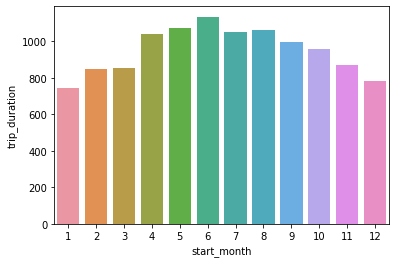

In [71]:
sns.barplot(x = a.start_month, y = a.trip_duration)

In [69]:
a = train_df.groupby('start_month').mean()[['trip_duration']].reset_index()

In [72]:
b = train_df.groupby('start_month').count()[['trip_duration']].reset_index()

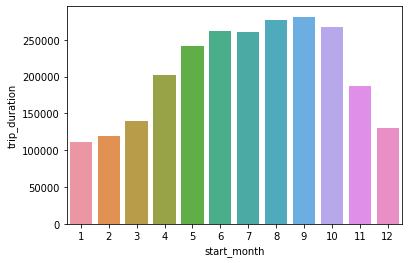

In [73]:
sns.barplot(x = b.start_month, y = b.trip_duration)

In [74]:
c = train_df.groupby('start_month').mean()[['distance']].reset_index()

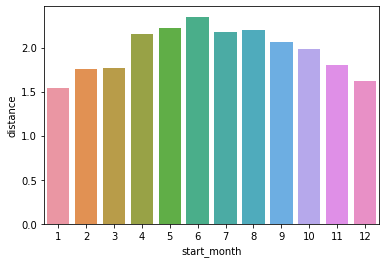

In [77]:
sns.barplot(x = c.start_month, y = c.distance)

In [78]:
weather = pd.read_csv('weather.csv',index_col = 0)
weather = weather.fillna(0)
weather.reset_index(inplace=True)
weather['DATE'] = pd.to_datetime(weather['DATE'])

,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze
0,2017-01-01,5.59,0.00,0.0,0.0,48,40,0.0,0.0,0.0,0.0,0.0,1.0
1,2017-01-02,9.17,0.21,0.0,0.0,41,37,1.0,0.0,0.0,1.0,0.0,0.0
2,2017-01-03,10.74,0.58,0.0,0.0,43,39,1.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-04,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0
4,2017-01-05,7.83,0.00,0.0,0.0,34,27,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,4.47,0.00,0.0,0.0,54,46,0.0,0.0,0.0,0.0,0.0,0.0
1091,2019-12-28,4.03,0.00,0.0,0.0,51,43,1.0,0.0,0.0,0.0,0.0,1.0
1092,2019-12-29,4.92,0.25,0.0,0.0,44,39,1.0,0.0,0.0,0.0,0.0,0.0
1093,2019-12-30,12.75,0.74,0.0,0.0,41,37,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
train_df['start_date'] = pd.to_datetime(train_df['start_date'])
train_df_weather = train_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

NameError: name 'weather' is not defined

In [84]:
test_df['start_date'] = pd.to_datetime(test_df['start_date'])
test_df_weather = test_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [ ]:
train_df_weather.to_csv('train_weather.csv')
test_df_weather.to_csv('test_weather.csv')